คราวนี้เราจะมาลองสร้าง Dataset ของตัวเอง เพื่อเทรนโมเดล 

* Eczema โรคผิวหนังอักเสบ โรคแพ้ผื่นคัน
* Psoriasis โรคสะเก็ดเงิน
* Acne Vulgaris โรคสิว โรคสิวธรรมดา
* Rosacea โรคผิวหนังอักเสบโรซาเชีย

# 0. Magic Commands


In [30]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# 1. Import Library

In [31]:
from fastai import *
from fastai.vision import *
from fastai.metrics import accuracy

# 2. ข้อมูล



In [32]:
folder = 'eczema'
file = 'urls_eczema.txt'

In [36]:
folder = 'psoriasis'
file = 'urls_psoriasis.txt'

In [44]:
folder = 'acne'
file = 'urls_acne.txt'

In [48]:
folder = 'rosacea'
file = 'urls_rosacea.txt'

Create folder and download all pictures in urls

In [49]:
path = Path('data/skin')
download_path = path/'downloads'
dest = download_path/folder
dest.mkdir(parents=True, exist_ok=True)

In [50]:
classes = ['eczema','psoriasis','acne', 'rosacea']

In [51]:
download_images(path/file, dest, max_pics=200)

Error https://www.healthplexus.net/files/content/2016/AboutRosacea/rosacea_mild_mod1.png HTTPSConnectionPool(host='www.healthplexus.net', port=443): Max retries exceeded with url: /files/content/2016/AboutRosacea/rosacea_mild_mod1.png (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))
Error http://www.aldasclinic.com/wp-content/uploads/2016/01/Rosacea.jpg HTTPSConnectionPool(host='www.aldasclinic.com', port=443): Max retries exceeded with url: /wp-content/uploads/2016/01/Rosacea.jpg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'certificate verify failed')])")))
Error https://bpac.org.nz/BPJ/2016/May/img/rosacea-intro.jpg HTTPSConnectionPool(host='bpac.org.nz', port=443): Max retries exceeded with url: /BPJ/2016/May/img/rosacea-intro.jpg (Caused by SSLError(SSLError("bad handshake: Error([('SSL routines', 'tls_process_server_certificate', 'cert

Check for broken files

In [52]:
for c in classes:
    print(c)
    verify_images(download_path/c, delete=True, max_size=500)

eczema


Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
cannot identify image file <_io.BufferedReader name='data/skin/downloads/eczema/00000175.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:952: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  ' expressed in bytes should be converted ' +


cannot identify image file <_io.BufferedReader name='data/skin/downloads/eczema/00000183.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/eczema/00000090.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/eczema/00000162.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


int() argument must be a string, a bytes-like object or a number, not 'tuple'
psoriasis


cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000099.jpeg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000087.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000056.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000185.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000136.jpeg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000155.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000197.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000032.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/psoriasis/00000143.jpg'>
cannot identify im

cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000120.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000155.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000152.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000073.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000071.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000139.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000196.png'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000192.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000057.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000148.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000198.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000089.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000022.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/00000180.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/acne/0000016

cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000172.png'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000083.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000025.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000169.png'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000191.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000016.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000189.jpg'>


/opt/anaconda3/lib/python3.7/site-packages/PIL/Image.py:1005: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry " +


cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000104.jpg'>
int() argument must be a string, a bytes-like object or a number, not 'tuple'
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000036.jpeg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000153.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000135.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000012.jpg'>
cannot identify image file <_io.BufferedReader name='data/skin/downloads/rosacea/00000158.jpg'>


# 3. เตรียมข้อมูล

เพิ่มขนาดรูปจาก 224 เป็น 299 และลดขนาด batch size เหลือ 64 เนื่องจากโมเดลที่ขนาดใหญ่ขึ้น มีความต้องการ Memory ที่มากขึ้น ถ้าใช้ Batch Size เท่าเดิมจะทำให้ Error GPU Out of Memory ได้

In [53]:
batchsize = 64
np.random.seed(55)

databunch = ImageDataBunch.from_folder(download_path, train='.', 
                                       valid_pct=0.2, 
                                       ds_tfms=get_transforms(), 
                                       size=320, bs=batchsize).normalize(imagenet_stats)

## สำรวจข้อมูล ##

ลองดูข้อมูล Batch แรก ด้วย show_batch สั่งให้แสดง รูป พร้อม label ชื่อพันธุ์ไว้บนรูป แสดง 3 แถว (rows) ในกรอบขนาด 12 x 9 นิ้ว (figsize)

*เราสามารถรัน cell นี้หลายครั้ง เพื่อเรียกดู batch ต่อ ๆ ไป ได้เรื่อย ๆ เป็นการสำรวจข้อมูล*

In [54]:
databunch.classes

['acne', 'eczema', 'psoriasis', 'rosacea']

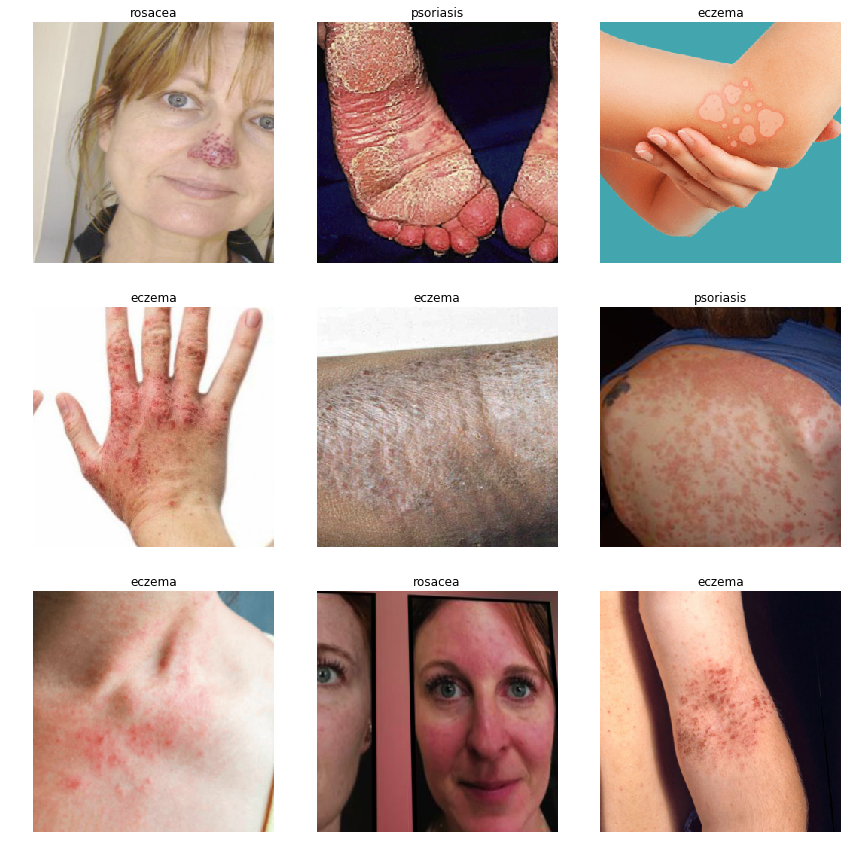

In [55]:
databunch.show_batch(rows=3, figsize=(12, 12))

In [56]:
databunch.classes, databunch.c, len(databunch.train_ds), len(databunch.valid_ds)

(['acne', 'eczema', 'psoriasis', 'rosacea'], 4, 586, 146)

# 4. สร้างโมเดล

เปลี่ยนจาก models.resnet34 เป็น models.resnet50

In [57]:
learner = cnn_learner(databunch, models.resnet50, metrics=accuracy)

# 5. เริ่มต้นเทรนโมเดล

เทรนด้วยค่า Default ไป 8 Cycle

In [58]:
learner.fit_one_cycle(8)

epoch,train_loss,valid_loss,accuracy,time
0,1.458343,1.083436,0.527397,00:11
1,1.105493,0.931904,0.671233,00:09
2,0.913987,0.900519,0.684932,00:09
3,0.813301,1.076674,0.671233,00:09
4,0.722277,0.882096,0.698630,00:09
5,0.647955,0.863279,0.719178,00:09
6,0.580894,0.861925,0.705479,00:09
7,0.534257,0.868429,0.719178,00:09


เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [59]:
learner.save('01d-resnet50-1')

โหลดโมเดลที่เรา Save ไว้ ขึ้นมาใหม่ เตรียมเทรนในขึ้นตอนถัดไป (ที่คอมเม้นท์ไว้ เพราะถ้าไม่ได้เปลี่ยนอะไรก็จะได้ไม่ต้องรัน)

In [60]:
# learner.load('01d-resnet50-1')

# 6. เทรนต่อ

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


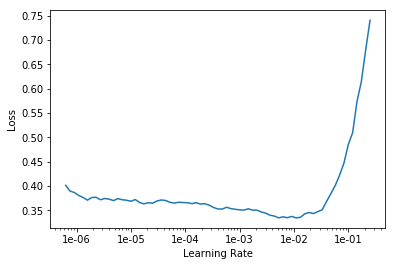

In [61]:
learner.lr_find()
learner.recorder.plot()

unfreeze layer ทุก Layer ให้สามารถเทรนได้ แล้วเทรนต่อทั้งโมเดล

In [62]:
learner.unfreeze()
learner.fit_one_cycle(6, max_lr=slice(3e-6,3e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.376198,0.853331,0.726027,00:12
1,0.368253,0.850656,0.698630,00:10
2,0.327927,0.889000,0.698630,00:10
3,0.309983,0.891954,0.719178,00:10
4,0.283233,0.908725,0.698630,00:10
5,0.257987,0.915004,0.698630,00:10


## สำเร็จแล้ว ##

เพียงแค่เวลา 10 นาทีเศษ เราเทรน Model ได้ accuracy ประมาณ 0.95 หรือ ความแม่นยำประมาณ 95%

เปรียบเทียบกับ 94.0% จาก ResNet34 ที่เราเทรนครั้งก่อน 

เรามา Save Model ที่เราเพิ่งเทรนไปเก็บไว้ก่อน

In [63]:
learner.save('01d-resnet50-2')

In [64]:
# learner.load('01d-resnet50-2')

# 7. ดูผลลัพธ์

In [65]:
interpretation = ClassificationInterpretation.from_learner(learner)

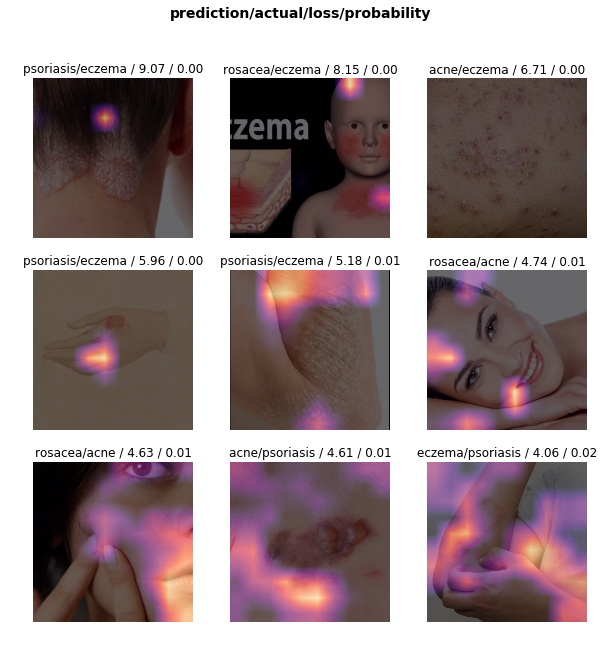

In [66]:
interpretation.plot_top_losses(9, figsize=(10,10))

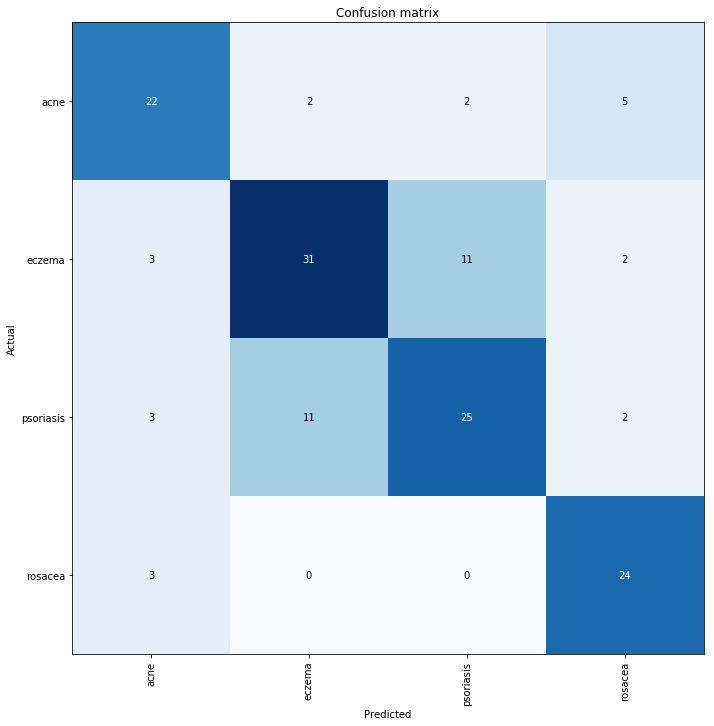

In [67]:
interpretation.plot_confusion_matrix(figsize=(10,10), dpi=72)

เรียกดู most_confused คือ พันธุ์ที่โมเดลทายผิดมากที่สุดเรียงลงไป

In [68]:
interpretation.most_confused(min_val=2)

[('eczema', 'psoriasis', 11),
 ('psoriasis', 'eczema', 11),
 ('acne', 'rosacea', 5),
 ('eczema', 'acne', 3),
 ('psoriasis', 'acne', 3),
 ('rosacea', 'acne', 3),
 ('acne', 'eczema', 2),
 ('acne', 'psoriasis', 2),
 ('eczema', 'rosacea', 2),
 ('psoriasis', 'rosacea', 2)]

Clean ข้อมูล

In [ ]:
from fastai.widgets import *

In [ ]:
ds, idxs = DatasetFormatter().from_toplosses(learner, ds_type=DatasetType.Valid)

In [ ]:
ImageCleaner(ds, idxs, path)

In [ ]:
ds, idxs = DatasetFormatter().from_similars(learner, ds_type=DatasetType.Valid)

In [ ]:
ImageCleaner(ds, idxs, path, duplicates=True)

# 8. สรุป


เปรียบเทียบกับเคสก่อนที่ใช้ ResNet34 กับ เคสนี้เราใช้ ResNet50 

* โมเดลใช้เวลาในการเทรนนานขึ้น จาก 3 นาที เป็น 10 นาที
* ใช้ memory GPU มากขึ้น 
* ประสิทธิภาพความแม่นยำดีขึ้น ประมาณ 1%

# Credit 

* [FastAI: Practical Deep Learning for Coders, v3 - Lesson 1](https://course.fast.ai/videos/?lesson=1)